In [87]:
from river.datasets import Insects 
from river.preprocessing import MinMaxScaler 
from river.metrics import Accuracy
from river.utils import Rolling
from river.tree import HoeffdingAdaptiveTreeClassifier
from river_torch.classification import Classifier
from torch import nn 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib
import torch

In [62]:
insects = Insects("abrupt_balanced")
scaler = MinMaxScaler()

class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 6)

    def forward(self, x):
        h = self.hidden(x)
        h = torch.relu(h)
        return self.logits(h)


model = Classifier(
    SimpleMLP, loss_fn="binary_cross_entropy_with_logits", optimizer_fn="sgd", lr=0.05, seed=42
)

In [ ]:
metric = Rolling(Accuracy(), window_size=400)
update_interval = 100
results = []
steps = []
step = 0
model2 = HoeffdingAdaptiveTreeClassifier()

for x, y in tqdm(list(insects)):
    x = scaler.learn_one(x).transform_one(x)
    y_pred = model2.predict_one(x)
    model2.learn_one(x, y)
    metric.update(y, y_pred)
    step += 1
    if step % update_interval == 0:
        results.append(metric.get())
        steps.append(step)

In [68]:
metric = Rolling(Accuracy(), window_size=400)
update_interval = 100
results = []
steps = []
step = 0
for x, y in tqdm(list(insects)):
    x = scaler.learn_one(x).transform_one(x)
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)
    step += 1
    if step % update_interval == 0:
        results.append(metric.get())
        steps.append(step)

100%|██████████| 52848/52848 [00:56<00:00, 932.66it/s]


Text(0, 0.5, 'Moving Accuracy')

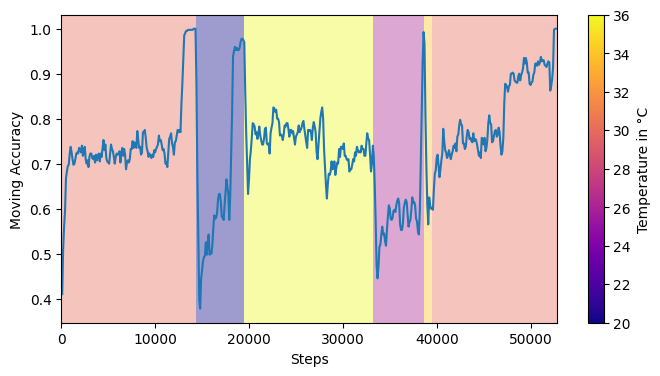

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(steps, results)
change_points = [0, 14352, 19500, 33240, 38682, 39510, 52848]
temps = [30, 20, 36, 26, 34, 30]
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize(vmin=20, vmax=36)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i in range(len(change_points)-1):
    ax.axvspan(change_points[i], change_points[i+1], alpha=0.4, color=cmap(norm(temps[i])), lw=0)
ax.set_xlim(0, change_points[-1])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_ylabel("Temperature in °C")
ax.set_xlabel("Steps")
ax.set_ylabel("Moving Accuracy")